In [204]:
! pip install pmdarima

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [205]:
! pip install pyramid-arima

  Using cached pyramid-arima-0.8.1.tar.gz (515 kB)
  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
    Running setup.py install for pyramid-arima: started
    Running setup.py install for pyramid-arima: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\44455\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\44455\\AppData\\Local\\Temp\\pip-install-stjye3t4\\pyramid-arima\\setup.py'"'"'; __file__='"'"'C:\\Users\\44455\\AppData\\Local\\Temp\\pip-install-stjye3t4\\pyramid-arima\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\44455\AppData\Local\Temp\pip-wheel-w4y8hk1g'
       cwd: C:\Users\44455\AppData\Local\Temp\pip-install-stjye3t4\pyramid-arima\
  Complete output (171 lines):
  Partial import of pyramid during the build process.
  Requirements: ['Cython>=0.23\nnumpy>=1.10\nscipy>=0.9\nscikit-learn>=0.17\npandas>=0.19\nstatsmodels>=0.9.0\n']
  Adding extra setuptools args
  blas_opt_info:
  blas_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutil

In [2]:
!pip install pandas_datareader

In [206]:
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
# plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pyramid.arima import auto_arima


import seaborn as sns 

# plt.style.use('seaborn-whitegrid')
%matplotlib inline

import itertools

# import numpy as np
# import yfinance as yf

ModuleNotFoundError: No module named 'pyramid'

In [117]:
# data = pd.read_csv('./data/AirPassengers.csv', parse_dates=['Month'], index_col='Month')


data = pd.read_csv('./data/AirPassengers.csv')
data = data.rename(columns={'Month' : 'month',
                           '#Passengers':'passengers'})
data['month']=pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


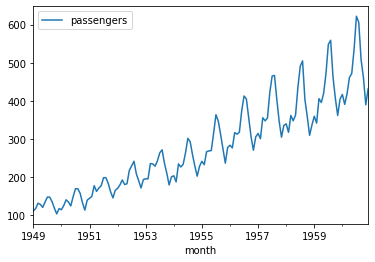

In [118]:
data.plot()

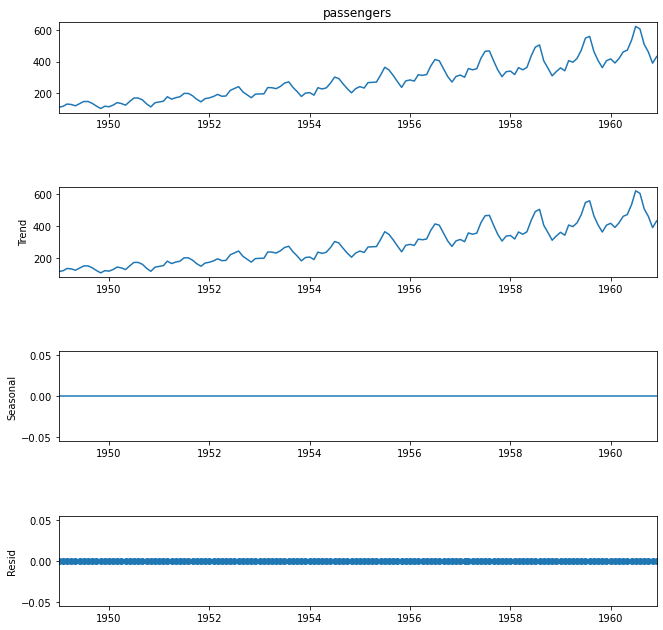

In [119]:
decompostion = sm.tsa.seasonal_decompose(data['passengers'], model='additive', period=1)
fig=decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

In [120]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False) #시계열(time series) 데이터이므로 셔플은 하지 않는다.

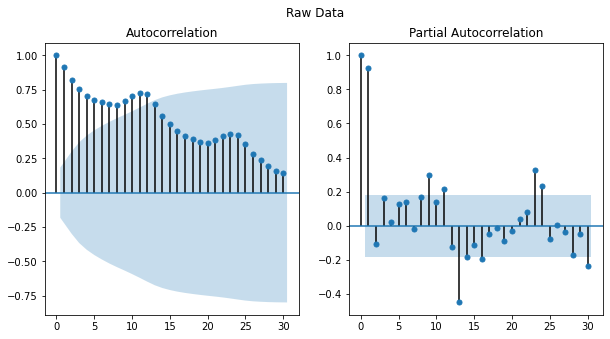

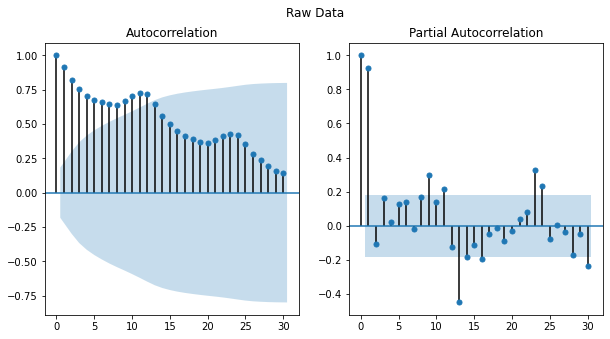

In [121]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

파도모형은 대체적으로 trend가 있어서 non stationary 할 경우 나타난다.

>> 위 분석을 통한 인사이트 : 정성적이게나마 non stationary 하다.

non stationary 한 데이터는 stationary하게 보정하기 위해 차분을 진행한다.
- 차분 : 현 시점 데이터에서 d 시점 이전 데이터를 뺀 것.

## 차분 진행

In [122]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()
diff_train_data = diff_train_data.dropna()

print('######### Raw Data ########')
print(train_data)
print('######Diffrenced Data #####')
print(diff_train_data)

######### Raw Data ########
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
######Diffrenced Data #####
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


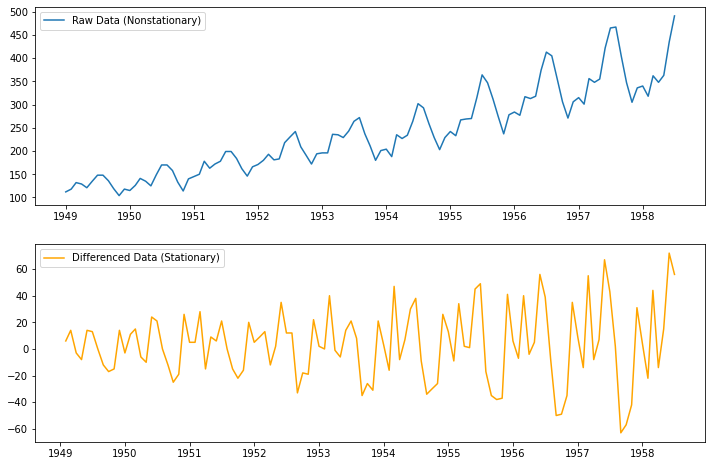

In [123]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

C:\Users\44455\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


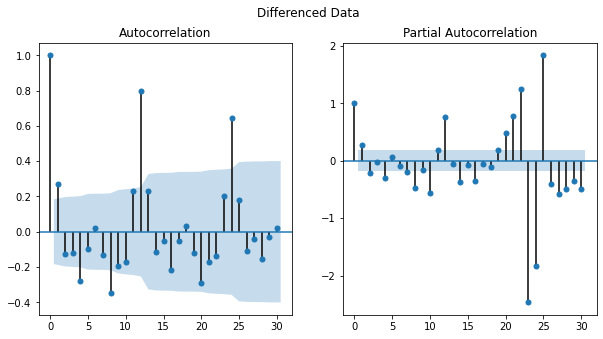

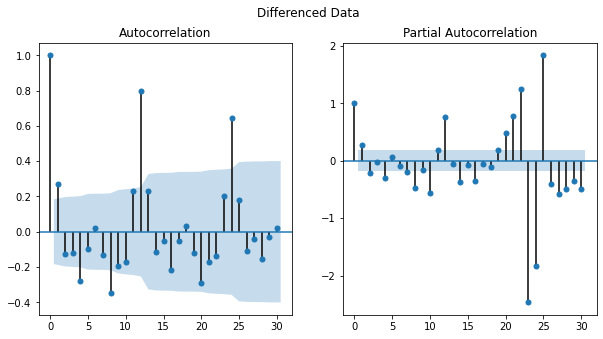

In [124]:
#  1차 차분 이후 시각화

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

In [125]:
model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Sat, 28 Nov 2020   AIC                           1069.440
Time:                        23:08:21   BIC                           1077.649
Sample:                             1   HQIC                          1072.771
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5124      3.329      1.055      0.291      -3.012      10.037
ar.L1.D.y      0.2803      0.091      3.077      0.002       0.102       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5681           +0.0000j            3.5681            0.0000
-----------------------------------------------------------------------------
"""

In [126]:
print('Examples of parameter combinations for Seasonal ARIMA')

p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

aic=[]

for i in pdq:
    model= ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA : {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

Examples of parameter combinations for Seasonal ARIMA
ARIMA : (0, 1, 0) >> AIC : 1076.52
ARIMA : (0, 1, 1) >> AIC : 1064.62
ARIMA : (0, 1, 2) >> AIC : 1061.08
ARIMA : (1, 1, 0) >> AIC : 1069.44
ARIMA : (1, 1, 1) >> AIC : 1058.83
ARIMA : (1, 1, 2) >> AIC : 1046.05
ARIMA : (2, 1, 0) >> AIC : 1066.2
ARIMA : (2, 1, 1) >> AIC : 1045.66
ARIMA : (2, 1, 2) >> AIC : 1047.19


In [127]:
# 위에서 aic 최소값을 찾기

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 1), 1045.66)]

In [128]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
# model_opt = ARIMA(train_data.values, order=(2,1,1))
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.317
Date:                Sat, 28 Nov 2020   AIC                           1045.660
Time:                        23:08:22   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.163     15.753      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.y     -0.9999      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1512           -0.8882j            1.4540           -0.1046
AR.2            1.1512           +0.8882j            1.4540            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

-> AIC 이전보다 훨씬 낮고, P-value값도 모두 0이라서 유의미함을 나타낸다.

In [132]:
# fc_series=pd.Series(fc, index=test.index)
# lower_series=pd.Series(conf[:,0], index=test.index)
# upper_series=pd.Series(conf[:,1], index=test.index)

In [133]:
prediction = model_opt_fit.forecast(len(test_data)) #test_Data 갯수만큼 예측
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

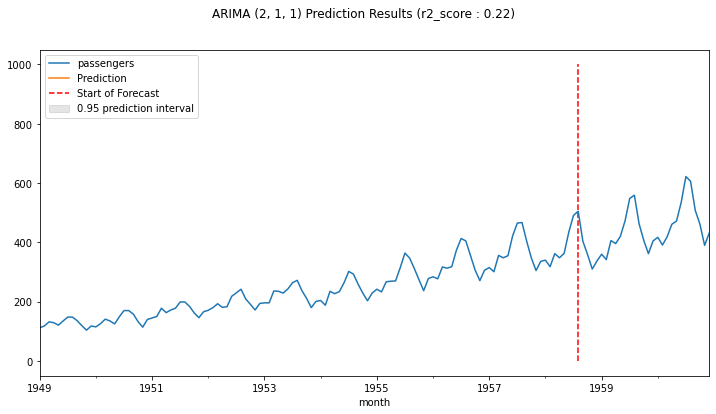

In [134]:
fig, ax=plt.subplots(figsize=(12,6))
data.plot(ax=ax); # 그릴 데이터 삽입
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast'); #예측 시점 선 긋기
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score : {round(r2,2)})')
plt.show()

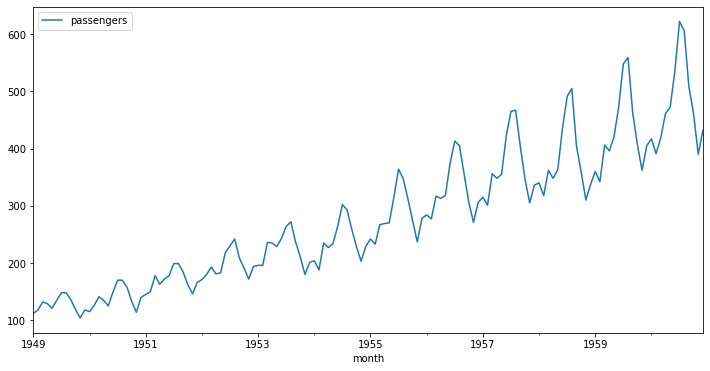

In [135]:
fig, ax=plt.subplots(figsize=(12,6))
data.plot(ax=ax); # 그릴 데이터 삽입


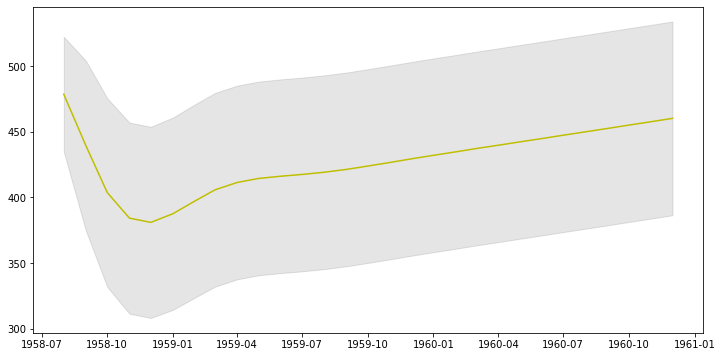

In [136]:
fig, ax=plt.subplots(figsize=(12,6))
# data.plot(ax=ax)
ax.plot(predict_index, predicted_value, label='Prediction',color='y')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
plt.show()

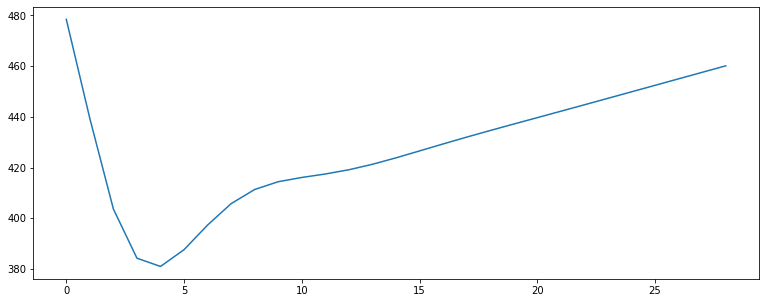

In [137]:
plt.figure(figsize=(13,5))
plt.plot(predicted_value, label='training')
plt.show()

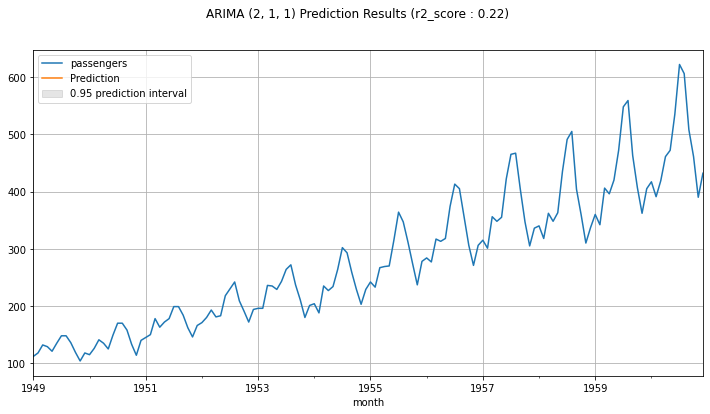

In [167]:
fig, ax=plt.subplots(figsize=(12,6))
data.plot(ax=ax); # 그릴 데이터 삽입
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score : {round(r2,2)})')
plt.grid(True)
plt.show()

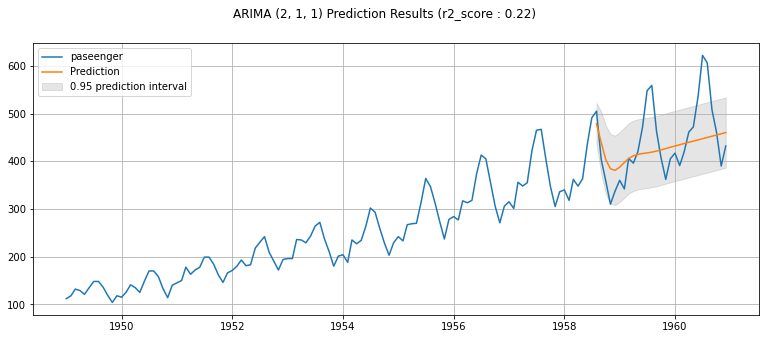

In [169]:
plt.figure(figsize=(13,5))
plt.plot(data, label='paseenger')
plt.plot(predict_index, predicted_value, label='Prediction')
plt.fill_between(predict_index, predicted_lb, predicted_ub, color='black', alpha=0.1, label='0.95 prediction interval')
plt.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score : {round(r2,2)})')
plt.grid(True)
plt.show()

# plt.vlines('1959-08-01', ymin = 0, ymax = 600, linestyle='dashed', color='r', label='Start of Forecast'); #예측 시점 선 긋기

-> R스퀘어드 22%나옴(높은건가?)
-> ARIMA는 seasonalyty까지는 반영이 안됨. 따라서 SARIMA 적용

-----------------------------

# SARIMA

In [173]:
print('Example of parameter combination for Seasonal ARIMA')

p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic=[]
params=[]

for i in pdq:
    for j in seasonal_pdq:
        try : 
            model= SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA : {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
        except :
            continue

Example of parameter combination for Seasonal ARIMA
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC : 757.83
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC : 756.99
SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC : 758.83
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC : 756.96
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC : 758.92
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC : 754.42
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC : 758.87
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC : 760.73


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC : 754.89
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC : 756.01
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC : 756.38
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC : 757.65
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC : 756.17
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC : 758.11
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC : 751.73
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC : 757.99
SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC : 753.78
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC : 757.78
SARIMA : (0, 1, 2)(0, 1, 1, 12) >> AIC : 758.04
SARIMA : (0, 1, 2)(0, 1, 2, 12) >> AIC : 759.28
SARIMA : (0, 1, 2)(1, 1, 0, 12) >> AIC : 757.81
SARIMA : (0, 1, 2)(1, 1, 1, 12) >> AIC : 759.75
SARIMA : (0, 1, 2)(1, 1, 2, 12) >> AIC : 753.5
SARIMA : (0, 1, 2)(2, 1, 0, 12) >> AIC : 759.64
SARIMA : (0, 1, 2)(2, 1, 1, 12) >> AIC : 755.49


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (0, 1, 2)(2, 1, 2, 12) >> AIC : 762.02
SARIMA : (1, 1, 0)(0, 1, 0, 12) >> AIC : 755.5
SARIMA : (1, 1, 0)(0, 1, 1, 12) >> AIC : 755.98
SARIMA : (1, 1, 0)(0, 1, 2, 12) >> AIC : 757.1
SARIMA : (1, 1, 0)(1, 1, 0, 12) >> AIC : 755.75
SARIMA : (1, 1, 0)(1, 1, 1, 12) >> AIC : 757.65
SARIMA : (1, 1, 0)(1, 1, 2, 12) >> AIC : 751.15
SARIMA : (1, 1, 0)(2, 1, 0, 12) >> AIC : 757.45
SARIMA : (1, 1, 0)(2, 1, 1, 12) >> AIC : 752.99
SARIMA : (1, 1, 1)(0, 1, 0, 12) >> AIC : 756.02
SARIMA : (1, 1, 1)(0, 1, 1, 12) >> AIC : 756.63
SARIMA : (1, 1, 1)(0, 1, 2, 12) >> AIC : 757.75
SARIMA : (1, 1, 1)(1, 1, 0, 12) >> AIC : 756.41
SARIMA : (1, 1, 1)(1, 1, 1, 12) >> AIC : 758.26
SARIMA : (1, 1, 1)(1, 1, 2, 12) >> AIC : 752.53
SARIMA : (1, 1, 1)(2, 1, 0, 12) >> AIC : 758.03
SARIMA : (1, 1, 1)(2, 1, 1, 12) >> AIC : 754.16
SARIMA : (1, 1, 2)(0, 1, 0, 12) >> AIC : 757.92
SARIMA : (1, 1, 2)(0, 1, 1, 12) >> AIC : 758.44
SARIMA : (1, 1, 2)(0, 1, 2, 12) >> AIC : 759.63
SARIMA : (1, 1, 2)(1, 1, 0, 12) >> AIC : 7

C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 2)(2, 1, 1, 12) >> AIC : 756.16


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 2)(2, 1, 2, 12) >> AIC : 762.86
SARIMA : (2, 1, 0)(0, 1, 0, 12) >> AIC : 756.77
SARIMA : (2, 1, 0)(0, 1, 1, 12) >> AIC : 757.23
SARIMA : (2, 1, 0)(0, 1, 2, 12) >> AIC : 758.31
SARIMA : (2, 1, 0)(1, 1, 0, 12) >> AIC : 756.98
SARIMA : (2, 1, 0)(1, 1, 1, 12) >> AIC : 758.86
SARIMA : (2, 1, 0)(1, 1, 2, 12) >> AIC : 752.78
SARIMA : (2, 1, 0)(2, 1, 0, 12) >> AIC : 758.65
SARIMA : (2, 1, 0)(2, 1, 1, 12) >> AIC : 754.51


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\44455\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA : (2, 1, 1)(0, 1, 0, 12) >> AIC : 757.98
SARIMA : (2, 1, 1)(0, 1, 1, 12) >> AIC : 758.54
SARIMA : (2, 1, 1)(0, 1, 2, 12) >> AIC : 759.69
SARIMA : (2, 1, 1)(1, 1, 0, 12) >> AIC : 758.31
SARIMA : (2, 1, 1)(1, 1, 1, 12) >> AIC : 760.18
SARIMA : (2, 1, 1)(1, 1, 2, 12) >> AIC : 754.53
SARIMA : (2, 1, 1)(2, 1, 0, 12) >> AIC : 759.98


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 1)(2, 1, 1, 12) >> AIC : 756.16


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 1)(2, 1, 2, 12) >> AIC : 762.23
SARIMA : (2, 1, 2)(0, 1, 0, 12) >> AIC : 755.2
SARIMA : (2, 1, 2)(0, 1, 1, 12) >> AIC : 755.99
SARIMA : (2, 1, 2)(0, 1, 2, 12) >> AIC : 759.77
SARIMA : (2, 1, 2)(1, 1, 0, 12) >> AIC : 755.82
SARIMA : (2, 1, 2)(1, 1, 1, 12) >> AIC : 757.71


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 2)(1, 1, 2, 12) >> AIC : 752.33
SARIMA : (2, 1, 2)(2, 1, 0, 12) >> AIC : 757.56
SARIMA : (2, 1, 2)(2, 1, 1, 12) >> AIC : 753.96


In [175]:
optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

# 가장 optimal한 즉, 가장 작은 AIC 값을 갖는 파라미터를 산출
# small pdq -> (1,1,0)
# large pdq -> (1,1,2) + 12(seasonal parameter)
#  ARIMA 보다 AIC 스코어 훨씬 낮음

[(((1, 1, 0), (1, 1, 2, 12)), 751.15)]

In [176]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
# model_opt = ARIMA(train_data.values, order=(2,1,1))
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -370.574
Date:                                 Sun, 29 Nov 2020   AIC                            751.149
Time:                                         01:15:12   BIC                            764.273
Sample:                                              0   HQIC                           756.463
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2363      0.092     -2.556      0.011      -0.417      -0.055
ar.S.L12       0.9984      0.190      5.259      0.000       0.626       1.371
ma.S.L12      -1.3677      2.351     -0.582      0.561      -5.976       3.240
ma.S.L24       0.3930      0.832      0.472      0.637      -1.237       2.023
sigma2        69.9606    152.036      0.460      0.645    -228.025     367.946
===================================================================================
Ljung-Box (Q):                       39.86   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.48   Prob(JB):                         0.25
Heteroskedasticity (H):               1.10   Skew:                             0.38
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [177]:
prediction = model_opt_fit.get_forecast(len(test_data)) #test_Data 갯수만큼 예측
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

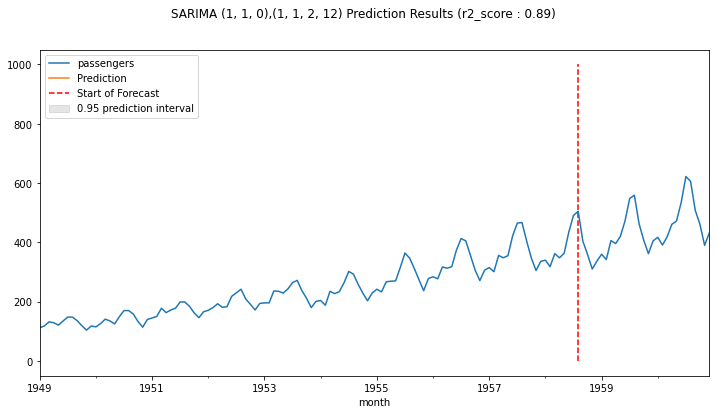

In [178]:
fig, ax=plt.subplots(figsize=(12,6))
data.plot(ax=ax); # 그릴 데이터 삽입
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast'); #예측 시점 선 긋기
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]},{optimal[0][0][1]} Prediction Results (r2_score : {round(r2,2)})')
plt.show()

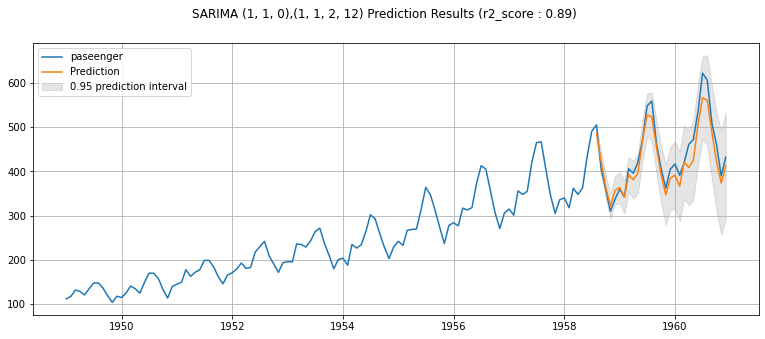

In [179]:
plt.figure(figsize=(13,5))
plt.plot(data, label='paseenger')
plt.plot(predict_index, predicted_value, label='Prediction')
plt.fill_between(predict_index, predicted_lb, predicted_ub, color='black', alpha=0.1, label='0.95 prediction interval')
plt.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]},{optimal[0][0][1]} Prediction Results (r2_score : {round(r2,2)})')
plt.grid(True)
plt.show()

-> r squared 89%

auto_arima

# 주가 예측

In [207]:
def get_code(df, name) : 
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code

In [208]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_data.head()

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
1,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,김태형,http://www.gsgcorp.com,서울특별시
2,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"권순호, 정경구",http://www.hdc-dvp.com,서울특별시
3,KG케미칼,1390,기초 화학물질 제조업,"콘크리트혼화제, 비료, 친환경농자재, 수처리제",1989-08-25,12월,"곽정현, 김재익",http://www.kgchem.co.kr,울산광역시
4,LG이노텍,11070,전자부품 제조업,기타 전자부품 제조업,2008-07-24,12월,정철동,http://www.lginnotek.co.kr,서울특별시


In [209]:
code_data = code_data[['회사명','종목코드']]
code_data = code_data.rename(columns={'회사명':'name', 
                                     '종목코드':'code'})
code_data.code = code_data.code.map('{:06d}'.format)
code_data.head()

,name,code
0,DSR,155660
1,GS글로벌,001250
2,HDC현대산업개발,294870
3,KG케미칼,001390
4,LG이노텍,011070


In [210]:
stock_code = get_code(code_data, 'LG이노텍')
stock_code = stock_code + '.KS'
stock_data = pdr.get_data_yahoo(stock_code)
stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-03,101000.0,98500.0,100500.0,99000.0,109582.0,97833.726562
2015-12-04,101500.0,97600.0,97700.0,99300.0,110494.0,98130.187500
2015-12-07,101000.0,98900.0,100500.0,99000.0,67414.0,97833.726562
2015-12-08,99300.0,95800.0,98800.0,96300.0,123389.0,95165.539062
2015-12-09,98400.0,96100.0,96400.0,97000.0,71398.0,95857.289062
...,...,...,...,...,...,...
2020-11-25,164000.0,158500.0,162000.0,159000.0,213338.0,159000.000000
2020-11-26,161000.0,157000.0,160500.0,160000.0,94007.0,160000.000000
2020-11-27,161000.0,158500.0,158500.0,160500.0,140059.0,160500.000000


고가, 저가, 시가, 종가, 거래량, 주신의분삭/배당/배분 등을 고려해 조정한 종가

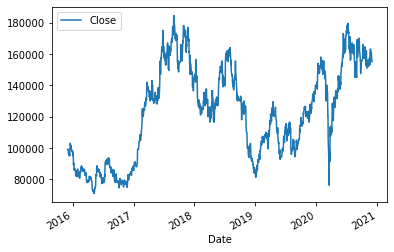

In [211]:
stock_data = stock_data[['Close']]
fig = stock_data.plot()

In [212]:
from sklearn.model_selection import train_test_split
stock_data_train, stock_data_test = train_test_split(stock_data, test_size=0.05, shuffle=False)

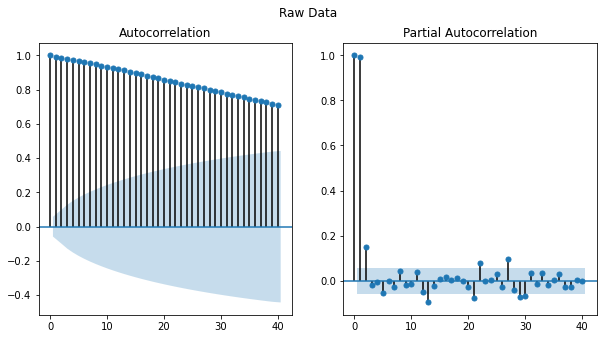

In [213]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags=40, ax=ax[1])
plt.show()

-> acf 플롯이 점진적으로 낮아지는 그래프는 대표적인 non stationary 데이터가 갖는 특성이다.

In [214]:
diff_stock_data_train = stock_data_train.copy()
diff_stock_data_train = diff_stock_data_train['Close'].diff()
diff_stock_data_train = diff_stock_data_train.dropna()

print('######### Raw Data ########')
print(stock_data_train)
print('######Diffrenced Data #####')
print(diff_stock_data_train)

######### Raw Data ########
               Close
Date                
2015-12-03   99000.0
2015-12-04   99300.0
2015-12-07   99000.0
2015-12-08   96300.0
2015-12-09   97000.0
...              ...
2020-08-26  149500.0
2020-08-27  146500.0
2020-08-28  147000.0
2020-08-31  145000.0
2020-09-01  153500.0

[1158 rows x 1 columns]
######Diffrenced Data #####
Date
2015-12-04     300.0
2015-12-07    -300.0
2015-12-08   -2700.0
2015-12-09     700.0
2015-12-10   -1900.0
               ...  
2020-08-26   -2500.0
2020-08-27   -3000.0
2020-08-28     500.0
2020-08-31   -2000.0
2020-09-01    8500.0
Name: Close, Length: 1157, dtype: float64


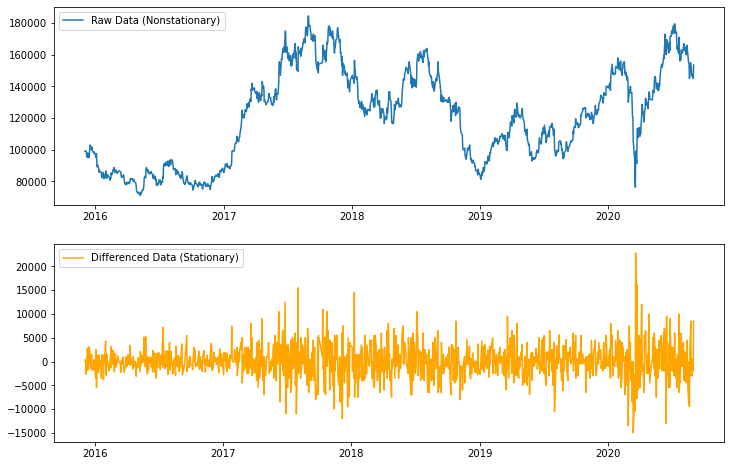

In [215]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(stock_data_train['Close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_stock_data_train, 'orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

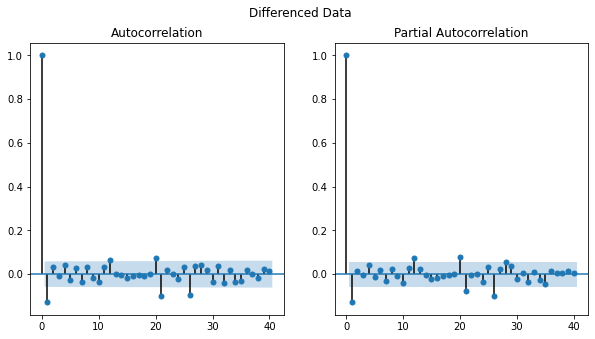

In [216]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[1])
plt.show()

In [200]:
auto_arima_model = auto_arima(stock_data_trian, start_p=1, start_q=1,
                              max_p =3, maq_q=3, seasonal = False,
                              d=1,
                              trace=True,
                              error_action='ignore',
                              suppress_waring= True,
                              sterpwise=False)

NameError: name 'auto_arima' is not defined

In [223]:
print('Example of parameter combination for Seasonal ARIMA')

p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic=[]
params=[]

for i in pdq:
    for j in seasonal_pdq:
        try : 
            model= SARIMAX(stock_data_train.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA : {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
        except :
            continue

Example of parameter combination for Seasonal ARIMA
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC : 22655.79
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC : 22195.39
SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC : 22118.65
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC : 22475.48
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC : 22125.68
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC : 22126.44
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC : 22336.33
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC : 22121.71
SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC : 22127.07
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC : 22638.35
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC : 22194.05


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC : 22107.1
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC : 22472.66
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC : 22114.01
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC : 22108.85
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC : 22364.33


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC : 22110.1
SARIMA : (0, 1, 1)(2, 1, 2, 12) >> AIC : 22227.88
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC : 22638.14
SARIMA : (0, 1, 2)(0, 1, 1, 12) >> AIC : 22194.73
SARIMA : (0, 1, 2)(0, 1, 2, 12) >> AIC : 22107.71
SARIMA : (0, 1, 2)(1, 1, 0, 12) >> AIC : 22470.78
SARIMA : (0, 1, 2)(1, 1, 1, 12) >> AIC : 22114.23
SARIMA : (0, 1, 2)(1, 1, 2, 12) >> AIC : 22109.48
SARIMA : (0, 1, 2)(2, 1, 0, 12) >> AIC : 22363.56
SARIMA : (0, 1, 2)(2, 1, 1, 12) >> AIC : 22110.73
SARIMA : (0, 1, 2)(2, 1, 2, 12) >> AIC : 22228.54
SARIMA : (1, 1, 0)(0, 1, 0, 12) >> AIC : 22637.16
SARIMA : (1, 1, 0)(0, 1, 1, 12) >> AIC : 22193.47
SARIMA : (1, 1, 0)(0, 1, 2, 12) >> AIC : 22106.37
SARIMA : (1, 1, 0)(1, 1, 0, 12) >> AIC : 22470.56
SARIMA : (1, 1, 0)(1, 1, 1, 12) >> AIC : 22113.18


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 0)(1, 1, 2, 12) >> AIC : 22108.14
SARIMA : (1, 1, 0)(2, 1, 0, 12) >> AIC : 22362.24
SARIMA : (1, 1, 0)(2, 1, 1, 12) >> AIC : 22109.37


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 0)(2, 1, 2, 12) >> AIC : 22117.02
SARIMA : (1, 1, 1)(0, 1, 0, 12) >> AIC : 22638.43
SARIMA : (1, 1, 1)(0, 1, 1, 12) >> AIC : 22199.39
SARIMA : (1, 1, 1)(0, 1, 2, 12) >> AIC : 22121.22
SARIMA : (1, 1, 1)(1, 1, 0, 12) >> AIC : 22471.71


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 1)(1, 1, 1, 12) >> AIC : 22127.93


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 1)(1, 1, 2, 12) >> AIC : 22138.49
SARIMA : (1, 1, 1)(2, 1, 0, 12) >> AIC : 22363.05


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 1)(2, 1, 1, 12) >> AIC : 22110.75


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 1)(2, 1, 2, 12) >> AIC : 22133.94
SARIMA : (1, 1, 2)(0, 1, 0, 12) >> AIC : 22639.28
SARIMA : (1, 1, 2)(0, 1, 1, 12) >> AIC : 22189.29


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 2)(0, 1, 2, 12) >> AIC : 22111.29
SARIMA : (1, 1, 2)(1, 1, 0, 12) >> AIC : 22472.13
SARIMA : (1, 1, 2)(1, 1, 1, 12) >> AIC : 22186.62


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 2)(1, 1, 2, 12) >> AIC : 22198.18
SARIMA : (1, 1, 2)(2, 1, 0, 12) >> AIC : 22365.4


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 2)(2, 1, 1, 12) >> AIC : 22114.39


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (1, 1, 2)(2, 1, 2, 12) >> AIC : 22230.09
SARIMA : (2, 1, 0)(0, 1, 0, 12) >> AIC : 22638.34
SARIMA : (2, 1, 0)(0, 1, 1, 12) >> AIC : 22194.64


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 0)(0, 1, 2, 12) >> AIC : 22107.69
SARIMA : (2, 1, 0)(1, 1, 0, 12) >> AIC : 22470.84
SARIMA : (2, 1, 0)(1, 1, 1, 12) >> AIC : 22114.3
SARIMA : (2, 1, 0)(1, 1, 2, 12) >> AIC : 22225.85
SARIMA : (2, 1, 0)(2, 1, 0, 12) >> AIC : 22362.59
SARIMA : (2, 1, 0)(2, 1, 1, 12) >> AIC : 22226.63


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 0)(2, 1, 2, 12) >> AIC : 22119.39
SARIMA : (2, 1, 1)(0, 1, 0, 12) >> AIC : 22639.48
SARIMA : (2, 1, 1)(0, 1, 1, 12) >> AIC : 22243.79


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 1)(0, 1, 2, 12) >> AIC : 22110.57
SARIMA : (2, 1, 1)(1, 1, 0, 12) >> AIC : 22471.94


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 1)(1, 1, 1, 12) >> AIC : 22116.71


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 1)(1, 1, 2, 12) >> AIC : 22128.55
SARIMA : (2, 1, 1)(2, 1, 0, 12) >> AIC : 22364.62


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 1)(2, 1, 1, 12) >> AIC : 22215.34


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 1)(2, 1, 2, 12) >> AIC : 22224.49
SARIMA : (2, 1, 2)(0, 1, 0, 12) >> AIC : 22641.28
SARIMA : (2, 1, 2)(0, 1, 1, 12) >> AIC : 22206.42
SARIMA : (2, 1, 2)(0, 1, 2, 12) >> AIC : 22229.12
SARIMA : (2, 1, 2)(1, 1, 0, 12) >> AIC : 22474.06
SARIMA : (2, 1, 2)(1, 1, 1, 12) >> AIC : 22131.87
SARIMA : (2, 1, 2)(1, 1, 2, 12) >> AIC : 22230.83
SARIMA : (2, 1, 2)(2, 1, 0, 12) >> AIC : 22367.06


C:\Users\44455\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA : (2, 1, 2)(2, 1, 1, 12) >> AIC : 22192.68


In [224]:
optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((1, 1, 0), (0, 1, 2, 12)), 22106.37)]

In [225]:
model_opt = SARIMAX(stock_data_train.values, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
# model_opt = ARIMA(train_data.values, order=(2,1,1))
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1158
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood              -11049.187
Date:                                 Wed, 02 Dec 2020   AIC                          22106.373
Time:                                         00:00:40   BIC                          22126.546
Sample:                                              0   HQIC                         22113.990
                                                - 1158                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0985      0.020     -4.877      0.000      -0.138      -0.059
ma.S.L12      -0.7513      0.032    -23.828      0.000      -0.813      -0.690
ma.S.L24      -0.2485      0.012    -21.292      0.000      -0.271      -0.226
sigma2      1.349e+07   2.38e-09   5.66e+15      0.000    1.35e+07    1.35e+07
===================================================================================
Ljung-Box (Q):                       71.19   Jarque-Bera (JB):               380.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.76e+30. Standard errors may be unstable.
"""

In [227]:
prediction = model_opt_fit.get_forecast(len(stock_data_test)) #test_Data 갯수만큼 예측
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(stock_data_test.index)
r2 = r2_score(stock_data_test, predicted_value)

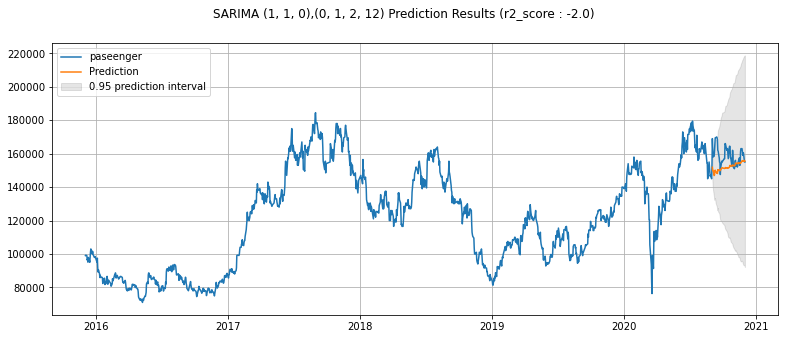

In [229]:
plt.figure(figsize=(13,5))
plt.plot(stock_data, label='paseenger')
plt.plot(predict_index, predicted_value, label='Prediction')
plt.fill_between(predict_index, predicted_lb, predicted_ub, color='black', alpha=0.1, label='0.95 prediction interval')
plt.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]},{optimal[0][0][1]} Prediction Results (r2_score : {round(r2,2)})')
plt.grid(True)
plt.show()